# Oregon Wildlife Image Classification
# Final Project

# Flatiron School - Washington DC
# Data Science Fellowship

### J. Mark Daniels, PhD

# Binary Classification - Bobcat

## Import Libraries for CNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import itertools
from keras import models
from keras.models import Model
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(123)
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import inception_v3
from keras.layers import Dense,GlobalAveragePooling2D

Using TensorFlow backend.


## Prepare Data

### Import, Resize, and Rescale Images

Build a function and export to .py to call these in to avoid conflicts

In [2]:
def imagenlabel_gen(test_dir, train_dir, images=None, labels=None):
    # Generate and resize images
    data_te = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        '/Users/j.markdaniels/Downloads/final_proj_data/bobcat_cougar_data/test/', 
        target_size=(224, 224), 
        batch_size = 340, 
        seed = 123)
    data_tr = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        '/Users/j.markdaniels/Downloads/final_proj_data/bobcat_cougar_data/train/', 
        target_size=(224, 224), 
        batch_size = 340, 
        seed = 123) 
    
    # Split images and labels into arrays
    images_te, labels_te = next(data_te)
    images_tr, labels_tr = next(data_tr)
    
    # Final images and labels
    images = np.concatenate((images_tr, images_te))
    labels = np.concatenate((labels_tr[:,0], labels_te[:,0]))
    
    return(images_te, labels_te,images_tr, labels_tr, images, labels)

In [3]:
cnn_test = '/Users/j.markdaniels/Downloads/final_proj_data/bobcat_cougar_data/test/'
cnn_train = '/Users/j.markdaniels/Downloads/final_proj_data/bobcat_cougar_data/train/'

In [4]:
images_te, labels_te,images_tr, labels_tr, images, labels = imagenlabel_gen(cnn_test, cnn_train)

Found 685 images belonging to 2 classes.
Found 680 images belonging to 2 classes.


/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 85 bytes but only got 0. Skipping tag 33285
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 93 bytes but only got 0. Skipping tag 33285
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 141 bytes but only got 0. Skipping tag 37386
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 149 bytes but only got 0. Skipping tag 37381
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read

/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [5]:
# data_te = ImageDataGenerator(rescale=1./255).flow_from_directory( 
#         '/Users/j.markdaniels/Downloads/final_proj_data/bobcat_cougar_data/test/', 
#         target_size=(224, 224), 
#         batch_size = 340, 
#         seed = 123)

In [6]:
# data_tr = ImageDataGenerator(rescale=1./255).flow_from_directory( 
#         '/Users/j.markdaniels/Downloads/final_proj_data/bobcat_cougar_data/train/', 
#         target_size=(224, 224), 
#         batch_size = 340, 
#         seed = 123) 

### Split Images and Labels into Arrays

Build a function and export to .py to call these in to avoid conflicts

In [7]:
# images_tr, labels_tr = next(data_tr)

# images_te, labels_te = next(data_te)

# images = np.concatenate((images_tr, images_te))

# labels = np.concatenate((labels_tr[:,0], labels_te[:,0]))

### Perform Train-Test Split

Build a function and export to .py to call these in to avoid conflicts

In [8]:
from sklearn.model_selection import train_test_split
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.20, random_state=123)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123)

## Convolutional Neural Network (CNN)

### Create Model

In [10]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (1, 1), activation='relu', input_shape=(224, 224,  3)))
cnn.add(layers.BatchNormalization())
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.BatchNormalization())
# 64 bias parameters
# 64 * (3 * 3 * 3) weight parametrs
# Output is 64*224*224
cnn.add(layers.MaxPooling2D((2, 2)))
#Output is 64*112*112
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224,  3)))
cnn.add(layers.BatchNormalization())
#32 bias parameters
#32 * (3*3*64)
#Output is 32*112*112 
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.


### Train Model

In [11]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=100, # 100
                    batch_size=50, #50
                    validation_data=(X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 435 samples, validate on 109 samples
Epoch 1/100
435/435 [==============================] - 56s 129ms/step - loss: 1.4276 - acc: 0.5931 - val_loss: 1.1248 - val_acc: 0.6514
Epoch 2/100
435/435 [==============================] - 52s 120ms/step - loss: 0.5554 - acc: 0.7678 - val_loss: 0.6978 - val_acc: 0.6972
Epoch 3/100
435/435 [==============================] - 51s 116ms/step - loss: 0.3215 - acc: 0.8713 - val_loss: 0.7529 - val_acc: 0.7156
Epoch 4/100
435/435 [==============================] - 52s 119ms/step - loss: 0.1671 - acc: 0.9333 - val_loss: 0.7437 - val_acc: 0.7339
Epoch 5/100
435/435 [==============================] - 51s 117ms/step - loss: 0.0840 - acc: 0.9724 - val_loss: 0.6139 - val_acc: 0.7982
Epoch 6/100
435/435 [==============================] - 50s 114ms/step - loss: 0.0589 - acc: 0.9793 - val_loss: 0.7033 - val_acc: 0.7615
Epoch 7/100
435/435 [==============================] - 50s 114ms/step - loss: 0.0293 - acc

435/435 [==============================] - 48s 110ms/step - loss: 1.4492e-04 - acc: 1.0000 - val_loss: 0.9016 - val_acc: 0.7982
Epoch 58/100
435/435 [==============================] - 49s 112ms/step - loss: 2.2440e-04 - acc: 1.0000 - val_loss: 0.9052 - val_acc: 0.7982
Epoch 59/100
435/435 [==============================] - 49s 113ms/step - loss: 1.2284e-04 - acc: 1.0000 - val_loss: 0.9109 - val_acc: 0.7982
Epoch 60/100
435/435 [==============================] - 48s 111ms/step - loss: 1.7419e-04 - acc: 1.0000 - val_loss: 0.9143 - val_acc: 0.7982
Epoch 61/100
435/435 [==============================] - 49s 113ms/step - loss: 1.3077e-04 - acc: 1.0000 - val_loss: 0.9165 - val_acc: 0.7982
Epoch 62/100
435/435 [==============================] - 49s 112ms/step - loss: 1.4943e-04 - acc: 1.0000 - val_loss: 0.9140 - val_acc: 0.7982
Epoch 63/100
435/435 [==============================] - 49s 113ms/step - loss: 1.1945e-04 - acc: 1.0000 - val_loss: 0.9154 - val_acc: 0.7982
Epoch 64/100
435/435 [====

### Save Loaded CNN Model

In [12]:
cnn.save('cnn1.h5')

### Load Saved CNN Model

In [13]:
# from numpy import loadtxt
# from keras.models import load_model


# cnn.load_weights('/Users/j.markdaniels/Desktop/flatiron_final_project/cnn_first_draft.h5')

# model = load_model('/Users/j.markdaniels/Desktop/flatiron_final_project/cnn_first_draft.h5')

# cnn.summary()



#### Summary

In [14]:
### Which should I keep? ###
print(cnn.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      256       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 110, 110, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 32)        18464     
__________

### Evaluate CNN Model Performance

Build a function and export to .py to call these in to avoid conflicts

In [15]:
from keras.callbacks import History 
history = History()

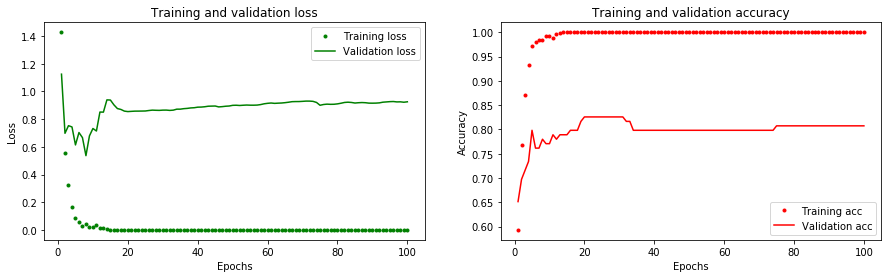

In [16]:
hist_cnn = cnn1.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['acc'] 
val_acc_values = hist_cnn['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Accuracy

Build a function and export to .py to call these in to avoid conflicts

In [17]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

136/136 [==============================] - 6s 47ms/step
[4.1923780272241104e-05, 1.0] [0.6363458160091849, 0.8235294117647058]


#### Confusion Matrix

In [18]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [19]:
predictions_transfer = cnn.predict(X_test)
predictions_transfer = np.around(predictions_transfer)

Confusion matrix, without normalization
[[56 10]
 [14 56]]


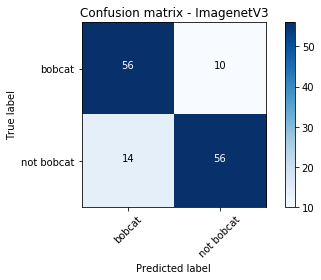

In [20]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predictions_transfer), classes=['bobcat', 'not bobcat'], normalize=False,
                      title='Confusion matrix - ImagenetV3')

#### F1 Score

In [21]:
f1_score(y_test, predictions_transfer)

0.823529411764706

### ROC Graph

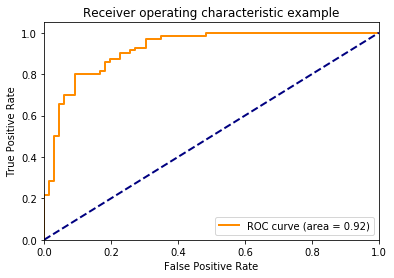

In [22]:
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

roc_predictions_transfer = cnn.predict(X_test)

fpr, tpr = roc_curve(y_test, roc_predictions_transfer)[:2]

auc_cnn = roc_auc_score(y_test, roc_predictions_transfer)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_cnn)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [23]:
fpr.shape

(39,)

In [24]:
tpr.shape

(39,)

In [25]:
roc_predictions_transfer

array([[4.47034836e-07],
       [1.93706155e-03],
       [6.47489548e-01],
       [2.41121650e-03],
       [9.22708154e-01],
       [2.89174914e-03],
       [1.79590225e-01],
       [1.23319924e-02],
       [2.24582851e-02],
       [9.97241199e-01],
       [9.99039888e-01],
       [4.22894955e-05],
       [3.02991271e-03],
       [9.99952793e-01],
       [3.01600099e-02],
       [3.10242176e-05],
       [1.40070915e-06],
       [1.22368336e-04],
       [7.62489796e-01],
       [9.99999642e-01],
       [2.24582851e-02],
       [8.80297899e-01],
       [4.68679667e-02],
       [5.99936903e-01],
       [9.99654412e-01],
       [6.83286309e-01],
       [9.99942899e-01],
       [3.29576373e-01],
       [1.00000000e+00],
       [0.00000000e+00],
       [8.85128975e-06],
       [9.28508759e-01],
       [1.30076319e-01],
       [5.74588776e-05],
       [9.99938011e-01],
       [3.81100684e-01],
       [5.85129261e-02],
       [2.06559837e-01],
       [2.38418579e-06],
       [7.46548176e-05],


## Convolutional Neural Network with Inception (CNN-i)

### Create Model

In [26]:
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new=imagenet.output
cnn_i = models.Sequential()
cnn_i.add(imagenet)
cnn_i.add(GlobalAveragePooling2D())
cnn_i.add(Dense(1024,activation='relu'))
cnn_i.add(Dense(1024,activation='relu')) #dense layer 2
cnn_i.add(Dense(512,activation='relu')) #dense layer 3
cnn_i.add(Dense(1,activation='sigmoid')) #final layer with sigmoid activation

In [27]:
for i,layer in enumerate(imagenet.layers):
  print(i,layer.name, layer.trainable)

0 input_1 False
1 conv2d_4 True
2 batch_normalization_4 True
3 activation_1 True
4 conv2d_5 True
5 batch_normalization_5 True
6 activation_2 True
7 conv2d_6 True
8 batch_normalization_6 True
9 activation_3 True
10 max_pooling2d_4 True
11 conv2d_7 True
12 batch_normalization_7 True
13 activation_4 True
14 conv2d_8 True
15 batch_normalization_8 True
16 activation_5 True
17 max_pooling2d_5 True
18 conv2d_12 True
19 batch_normalization_12 True
20 activation_9 True
21 conv2d_10 True
22 conv2d_13 True
23 batch_normalization_10 True
24 batch_normalization_13 True
25 activation_7 True
26 activation_10 True
27 average_pooling2d_1 True
28 conv2d_9 True
29 conv2d_11 True
30 conv2d_14 True
31 conv2d_15 True
32 batch_normalization_9 True
33 batch_normalization_11 True
34 batch_normalization_14 True
35 batch_normalization_15 True
36 activation_6 True
37 activation_8 True
38 activation_11 True
39 activation_12 True
40 mixed0 True
41 conv2d_19 True
42 batch_normalization_19 True
43 activation_16 True


In [28]:
for i,layer in enumerate(cnn_i.layers):
  print(i,layer.name, layer.trainable)

0 inception_v3 True
1 global_average_pooling2d_1 True
2 dense_3 True
3 dense_4 True
4 dense_5 True
5 dense_6 True


In [29]:
for layer in cnn_i.layers[:1]:
    layer.trainable=False

In [30]:
for i,layer in enumerate(cnn_i.layers):
  print(i,layer.name, layer.trainable)

0 inception_v3 False
1 global_average_pooling2d_1 True
2 dense_3 True
3 dense_4 True
4 dense_5 True
5 dense_6 True


### Train Model

In [31]:
cnn_i.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

# step_size_train=train_generator.n//train_generator.batch_size
cnn_i_1= cnn_i.fit(X_train,
          y_train,
          epochs=100, # 100
          batch_size=50, # 50
          validation_data=(X_val, y_val))

Train on 435 samples, validate on 109 samples
Epoch 1/100
435/435 [==============================] - 50s 115ms/step - loss: 0.8741 - acc: 0.5793 - val_loss: 0.3246 - val_acc: 0.8899
Epoch 2/100
435/435 [==============================] - 38s 87ms/step - loss: 0.3431 - acc: 0.8598 - val_loss: 0.2833 - val_acc: 0.9541
Epoch 3/100
435/435 [==============================] - 38s 86ms/step - loss: 0.2553 - acc: 0.9057 - val_loss: 0.3803 - val_acc: 0.9450
Epoch 4/100
435/435 [==============================] - 37s 84ms/step - loss: 0.2403 - acc: 0.9011 - val_loss: 0.3440 - val_acc: 0.9450
Epoch 5/100
435/435 [==============================] - 38s 87ms/step - loss: 0.1214 - acc: 0.9540 - val_loss: 0.3332 - val_acc: 0.9450
Epoch 6/100
435/435 [==============================] - 37s 85ms/step - loss: 0.0474 - acc: 0.9839 - val_loss: 0.4180 - val_acc: 0.9450
Epoch 7/100
435/435 [==============================] - 37s 84ms/step - loss: 0.0710 - acc: 0.9793 - val_loss: 0.4749 - val_acc: 0.9266
Epoch 8/

Epoch 61/100
435/435 [==============================] - 36s 83ms/step - loss: 0.0123 - acc: 0.9977 - val_loss: 0.5747 - val_acc: 0.9358
Epoch 62/100
435/435 [==============================] - 35s 81ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.7070 - val_acc: 0.9358
Epoch 63/100
435/435 [==============================] - 36s 83ms/step - loss: 9.1695e-04 - acc: 1.0000 - val_loss: 0.6515 - val_acc: 0.9541
Epoch 64/100
435/435 [==============================] - 36s 83ms/step - loss: 0.0086 - acc: 0.9977 - val_loss: 0.7524 - val_acc: 0.9358
Epoch 65/100
435/435 [==============================] - 37s 85ms/step - loss: 0.0079 - acc: 0.9977 - val_loss: 0.6583 - val_acc: 0.9450
Epoch 66/100
435/435 [==============================] - 36s 83ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.6499 - val_acc: 0.9541
Epoch 67/100
435/435 [==============================] - 37s 85ms/step - loss: 0.0031 - acc: 0.9977 - val_loss: 0.7271 - val_acc: 0.9358
Epoch 68/100
435/435 [======================

### Save Loaded CNN-i Model

In [32]:
cnn_i.save('cnn_i.h5')

### Load Saved CNN-i Model

In [33]:

# from numpy import loadtxt
# from keras.models import load_model


# cnn_i.load_weights('/Users/j.markdaniels/iCloud Drive (Archive)/Desktop/Flatiron/projects/Final_Project/final_project/flatiron_final_project/cnn_i.h5')

# model = load_model('/Users/j.markdaniels/iCloud Drive (Archive)/Desktop/Flatiron/projects/Final_Project/final_project/flatiron_final_project/cnn_i.h5')

# cnn_i.summary()



#### Summary

In [34]:
print(cnn_i.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 25,475,873
Trainable params: 3,673,089
Non-trainable params: 21,802,784
________________________________________________________

### Evaluate CNN-i Model Performance

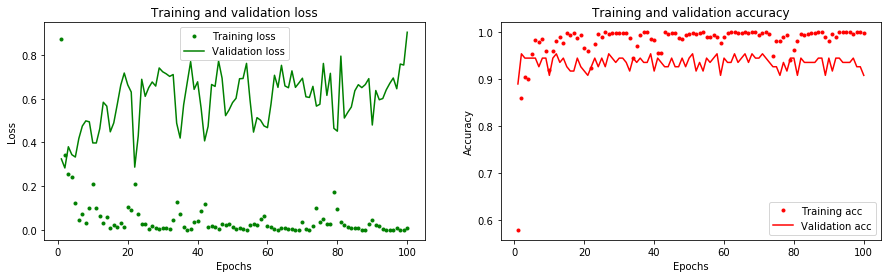

In [35]:
hist_cnn_i = cnn_i_1.history
loss_values = hist_cnn_i['loss']
val_loss_values = hist_cnn_i['val_loss']
acc_values = hist_cnn_i['acc'] 
val_acc_values = hist_cnn_i['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
# hist_cnn_i = cnn_i.history
# loss_values = hist_cnn_i['loss']
# val_loss_values = hist_cnn_i['val_loss']
# acc_values = hist_cnn_i['acc'] 
# val_acc_values = hist_cnn_i['val_acc']


# epochs = range(1, len(loss_values) + 1)

# plt.figure(figsize=(15,4))
# plt.subplot(121)
# plt.plot(epochs, loss_values, 'g.', label='Training loss')
# plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(122)
# plt.plot(epochs, acc_values, 'r.', label='Training acc')
# plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

#### Accuracy

In [37]:
results_train = cnn_i.evaluate(X_train, y_train)
results_test = cnn_i.evaluate(X_test, y_test)
print(results_train, results_test)

136/136 [==============================] - 10s 73ms/step
[0.6942408467161244, 0.9218390814189253] [0.978951773222755, 0.8823529411764706]


#### Confusion Matrix

In [38]:
predictions_transfer_cnn_i = cnn_i.predict(X_test)
predictions_transfer_cnn_i = np.around(predictions_transfer)

Confusion matrix, without normalization
[[56 10]
 [14 56]]


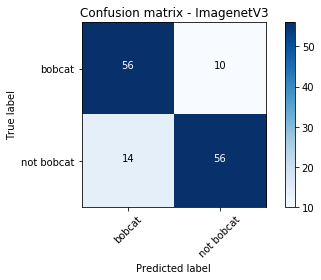

In [39]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, predictions_transfer_cnn_i), classes=['bobcat', 'not bobcat'], normalize=False,
                      title='Confusion matrix - ImagenetV3')

#### F1 Score

In [40]:
predictions_transfer_cnn_i = cnn_i.predict(X_test)
predictions_transfer_cnn_i = np.around(predictions_transfer)

In [41]:
f1_score(y_test, predictions_transfer_cnn_i)

0.823529411764706

#### ROC Graph

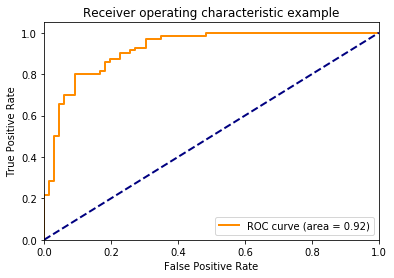

In [42]:
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

roc_predictions_transfer = cnn.predict(X_test)

fpr, tpr = roc_curve(y_test, roc_predictions_transfer)[:2]

auc_cnn_i = roc_auc_score(y_test, roc_predictions_transfer)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_cnn)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 20-class Wildlife Classification

## Import Libraries for Multiclass CNN with Inception

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import os
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import functools

from keras import models
from keras import layers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from shutil import copy2

from keras.applications import inception_v3
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.metrics import top_k_categorical_accuracy

np.random.seed(123)

## Prepare Data

### Import, Resize, and Rescale Images

In [44]:
multi_data_te = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        '/Users/j.markdaniels/Desktop/Data/multiclass/test/', 
        target_size=(224, 224), 
        batch_size = 2776, 
        class_mode='categorical',
        seed = 123)

multi_data_tr = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        '/Users/j.markdaniels/Desktop/Data/multiclass/train/', 
        target_size=(224, 224), 
        batch_size = 340, 
        class_mode='categorical',
        seed = 123) 

Found 2776 images belonging to 20 classes.
Found 11179 images belonging to 20 classes.


In [ ]:
# def imagenlabel_gen_multi(test_dir, train_dir, images=None, labels=None):
#     # Generate and resize images
#     multi_data_te = ImageDataGenerator(rescale=1./255).flow_from_directory( 
#         '/Users/j.markdaniels/Desktop/Data/multiclass/test/', 
#         target_size=(224, 224), 
#         batch_size = 2776, 
#         class_mode='categorical',
#         seed = 123)
#     multi_data_tr = ImageDataGenerator(rescale=1./255).flow_from_directory( 
#         '/Users/j.markdaniels/Desktop/Data/multiclass/train/', 
#         target_size=(224, 224), 
#         batch_size = 340, 
#         class_mode='categorical',
#         seed = 123) 
    
#     # Split images and labels into arrays
#     multi_images_te, multi_labels_te = next(multi_data_te)
#     multi_images_tr, multi_labels_tr = next(multi_data_tr)
    
#     # Final images and labels
#     multi_images = np.concatenate((multi_images_tr, multi_images_te))
#     multi_labels = np.concatenate((multi_labels_tr[:,0], multi_labels_te[:,0]))
    
#     return(multi_images_te, multi_labels_te,multi_images_tr, multi_labels_tr, multi_images, multi_labels)

### Split Images and Labels into Arrays

In [45]:
multi_images_tr, multi_labels_tr = next(multi_data_tr)

/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 85 bytes but only got 0. Skipping tag 33285
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 93 bytes but only got 0. Skipping tag 33285
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 141 bytes but only got 0. Skipping tag 37386
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 149 bytes but only got 0. Skipping tag 37381
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read

/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


In [46]:
multi_images_te, multi_labels_te = next(multi_data_te)

In [47]:
multi_images = np.concatenate((multi_images_tr, multi_images_te))
multi_labels = np.concatenate((multi_labels_tr[:,0], multi_labels_te[:,0]))

In [48]:
# multi_test = '/Users/j.markdaniels/Desktop/Data/multiclass/test/'
# multi_train = '/Users/j.markdaniels/Desktop/Data/multiclass/train/'

In [49]:
# multi_images_te, multi_labels_te,multi_images_tr, multi_labels_tr, multi_images, multi_labels = imagenlabel_gen_multi(multi_test, multi_train)

### Perform Train-Test Split

In [50]:
X_train, X_val, y_train, y_val = train_test_split(multi_images_tr, multi_labels_tr, test_size=0.20, random_state=123)

In [51]:
y_test  = multi_labels_te

In [52]:
y_test.shape

(2776, 20)

In [55]:
X_train.shape

(272, 224, 224, 3)

In [53]:
X_test = multi_images_te

In [54]:
X_test.shape

(2776, 224, 224, 3)

## Multi-class CNN-i Model

### Create Model

In [56]:
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new=imagenet.output
multi_class_model = models.Sequential()
multi_class_model.add(imagenet)
multi_class_model.add(GlobalAveragePooling2D())
multi_class_model.add(Dense(1024,activation='relu'))
multi_class_model.add(Dense(1024,activation='relu')) #dense layer 2
multi_class_model.add(Dense(512,activation='relu')) #dense layer 3
multi_class_model.add(Dense(20,activation='softmax')) #final layer with softmax activation

In [57]:
for i,layer in enumerate(imagenet.layers):
  print(i,layer.name, layer.trainable)

0 input_2 False
1 conv2d_98 True
2 batch_normalization_98 True
3 activation_95 True
4 conv2d_99 True
5 batch_normalization_99 True
6 activation_96 True
7 conv2d_100 True
8 batch_normalization_100 True
9 activation_97 True
10 max_pooling2d_8 True
11 conv2d_101 True
12 batch_normalization_101 True
13 activation_98 True
14 conv2d_102 True
15 batch_normalization_102 True
16 activation_99 True
17 max_pooling2d_9 True
18 conv2d_106 True
19 batch_normalization_106 True
20 activation_103 True
21 conv2d_104 True
22 conv2d_107 True
23 batch_normalization_104 True
24 batch_normalization_107 True
25 activation_101 True
26 activation_104 True
27 average_pooling2d_10 True
28 conv2d_103 True
29 conv2d_105 True
30 conv2d_108 True
31 conv2d_109 True
32 batch_normalization_103 True
33 batch_normalization_105 True
34 batch_normalization_108 True
35 batch_normalization_109 True
36 activation_100 True
37 activation_102 True
38 activation_105 True
39 activation_106 True
40 mixed0 True
41 conv2d_113 True
42 

In [58]:
for i,layer in enumerate(multi_class_model.layers):
  print(i,layer.name, layer.trainable)

0 inception_v3 True
1 global_average_pooling2d_2 True
2 dense_7 True
3 dense_8 True
4 dense_9 True
5 dense_10 True


In [59]:
for layer in multi_class_model.layers[:1]:
    layer.trainable=False

In [60]:
for i,layer in enumerate(multi_class_model.layers):
  print(i,layer.name, layer.trainable)

0 inception_v3 False
1 global_average_pooling2d_2 True
2 dense_7 True
3 dense_8 True
4 dense_9 True
5 dense_10 True


In [61]:
y_val.shape

(68, 20)

### Train Model

In [62]:
# top5_accuracy = functools.partial(top_k_categorical_accuracy, k=5)

top3_acc = functools.partial(top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

In [63]:
multi_class_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy', top3_acc])

In [64]:
multi_class_model_1 = multi_class_model.fit(X_train,
                                          y_train,
                                          epochs=100, #100
                                          batch_size=60, #60
                                          validation_data=(X_val, y_val))

Train on 272 samples, validate on 68 samples
Epoch 1/100
272/272 [==============================] - 40s 147ms/step - loss: 2.9203 - acc: 0.1066 - top3_acc: 0.2684 - val_loss: 2.4718 - val_acc: 0.3235 - val_top3_acc: 0.5294
Epoch 2/100
272/272 [==============================] - 23s 83ms/step - loss: 1.8550 - acc: 0.5221 - top3_acc: 0.7206 - val_loss: 2.3592 - val_acc: 0.3971 - val_top3_acc: 0.7647
Epoch 3/100
272/272 [==============================] - 22s 83ms/step - loss: 1.0322 - acc: 0.7500 - top3_acc: 0.8750 - val_loss: 1.5893 - val_acc: 0.5588 - val_top3_acc: 0.8824
Epoch 4/100
272/272 [==============================] - 23s 83ms/step - loss: 0.5896 - acc: 0.8456 - top3_acc: 0.9596 - val_loss: 2.1274 - val_acc: 0.4853 - val_top3_acc: 0.8235
Epoch 5/100
272/272 [==============================] - 23s 83ms/step - loss: 0.3351 - acc: 0.8971 - top3_acc: 0.9743 - val_loss: 1.6099 - val_acc: 0.6618 - val_top3_acc: 0.9118
Epoch 6/100
272/272 [==============================] - 22s 83ms/step 

272/272 [==============================] - 22s 82ms/step - loss: 3.8548e-04 - acc: 1.0000 - top3_acc: 1.0000 - val_loss: 2.3823 - val_acc: 0.6765 - val_top3_acc: 0.9265
Epoch 47/100
272/272 [==============================] - 22s 82ms/step - loss: 1.1676e-04 - acc: 1.0000 - top3_acc: 1.0000 - val_loss: 2.4037 - val_acc: 0.6471 - val_top3_acc: 0.9265
Epoch 48/100
272/272 [==============================] - 24s 89ms/step - loss: 1.1592e-04 - acc: 1.0000 - top3_acc: 1.0000 - val_loss: 2.4291 - val_acc: 0.6618 - val_top3_acc: 0.9118
Epoch 49/100
272/272 [==============================] - 22s 82ms/step - loss: 7.6093e-05 - acc: 1.0000 - top3_acc: 1.0000 - val_loss: 2.4364 - val_acc: 0.6471 - val_top3_acc: 0.9118
Epoch 50/100
272/272 [==============================] - 23s 84ms/step - loss: 1.3612e-04 - acc: 1.0000 - top3_acc: 1.0000 - val_loss: 2.4449 - val_acc: 0.6471 - val_top3_acc: 0.9118
Epoch 51/100
272/272 [==============================] - 22s 82ms/step - loss: 1.1094e-04 - acc: 1.0000 

272/272 [==============================] - 22s 82ms/step - loss: 4.8660e-05 - acc: 1.0000 - top3_acc: 1.0000 - val_loss: 2.1799 - val_acc: 0.6618 - val_top3_acc: 0.9265
Epoch 92/100
272/272 [==============================] - 22s 82ms/step - loss: 2.1556e-05 - acc: 1.0000 - top3_acc: 1.0000 - val_loss: 2.1815 - val_acc: 0.6618 - val_top3_acc: 0.9265
Epoch 93/100
272/272 [==============================] - 23s 84ms/step - loss: 3.1444e-05 - acc: 1.0000 - top3_acc: 1.0000 - val_loss: 2.1835 - val_acc: 0.6471 - val_top3_acc: 0.9265
Epoch 94/100
272/272 [==============================] - 22s 82ms/step - loss: 4.9000e-05 - acc: 1.0000 - top3_acc: 1.0000 - val_loss: 2.1814 - val_acc: 0.6618 - val_top3_acc: 0.9265
Epoch 95/100
272/272 [==============================] - 23s 83ms/step - loss: 4.3540e-05 - acc: 1.0000 - top3_acc: 1.0000 - val_loss: 2.1676 - val_acc: 0.6471 - val_top3_acc: 0.9265
Epoch 96/100
272/272 [==============================] - 23s 83ms/step - loss: 2.7275e-05 - acc: 1.0000 

### Save Loaded Multi-class Model

In [65]:
multi_class_model.save('multiple_classes.h5')

### Load Saved Multi-class Model

In [66]:
# from numpy import loadtxt
# from keras.models import load_model


# multi_class_model.load_weights('/Users/j.markdaniels/iCloud Drive (Archive)/Desktop/Flatiron/projects/Final_Project/final_project/flatiron_final_project/inception_multiple_classes.h5')

# model = load_model('/Users/j.markdaniels/iCloud Drive (Archive)/Desktop/Flatiron/projects/Final_Project/final_project/flatiron_final_project/inception_multiple_classes.h5')

# multi_class_model.summary()


#### Summary

In [67]:

print(multi_class_model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_10 (Dense)             (None, 20)                10260     
Total params: 25,485,620
Trainable params: 3,682,836
Non-trainable params: 21,802,784
________________________________________________________

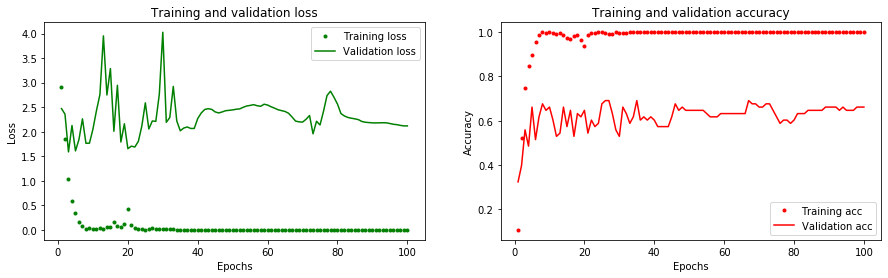

In [68]:
hist_multi = multi_class_model_1.history
loss_values = hist_multi['loss']
val_loss_values = hist_multi['val_loss']
acc_values = hist_multi['acc'] 
val_acc_values = hist_multi['val_acc']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g.', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'r.', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluate Model

#### Accuracy

In [69]:
multi_class_model.evaluate(X_test, y_test)

2776/2776 [==============================] - 201s 72ms/step


[2.4385253180687982, 0.6887608067446552, 0.917507204610951]

#### Confusion Matrix

In [70]:
predictions_transfer = multi_class_model.predict(X_test)

In [71]:
labels = [label for label in multi_data_te.class_indices] 
labels

['bald_eagle_test',
 'black_bear_test',
 'bobcat_test',
 'canada_lynx_test',
 'columbian_deer_test',
 'cougar_test',
 'coyote_test',
 'deer_test',
 'elk_test',
 'gray_fox_test',
 'gray_wolf_test',
 'mountain_beaver_test',
 'nutria_test',
 'raccoon_test',
 'raven_test',
 'red_fox_test',
 'ringtail_test',
 'sea_lions_test',
 'seals_test',
 'virginia_opossum_test']

Top 3 guesses: ['cougar', 'canada_lynx', 'bald_eagle']
cougar


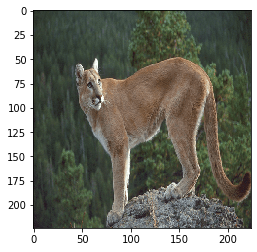

In [72]:


k = 3
i=890
top_k_predictions = [x[:k] for x in (-predictions_transfer).argsort()]
top_values_index=top_k_predictions[i]
plt.imshow(X_test[i])
print('Top 3 guesses: {}'.format([labels[i].replace('_test','') for i in top_values_index]))
print(labels[y_test[i].argmax()].replace('_test',''))

In [73]:
multi_data_te.class_indices


{'bald_eagle_test': 0,
 'black_bear_test': 1,
 'bobcat_test': 2,
 'canada_lynx_test': 3,
 'columbian_deer_test': 4,
 'cougar_test': 5,
 'coyote_test': 6,
 'deer_test': 7,
 'elk_test': 8,
 'gray_fox_test': 9,
 'gray_wolf_test': 10,
 'mountain_beaver_test': 11,
 'nutria_test': 12,
 'raccoon_test': 13,
 'raven_test': 14,
 'red_fox_test': 15,
 'ringtail_test': 16,
 'sea_lions_test': 17,
 'seals_test': 18,
 'virginia_opossum_test': 19}

In [74]:
y_pred = np.argmax(predictions_transfer, axis=1)

y_true = np.where(y_test != 0)[1]

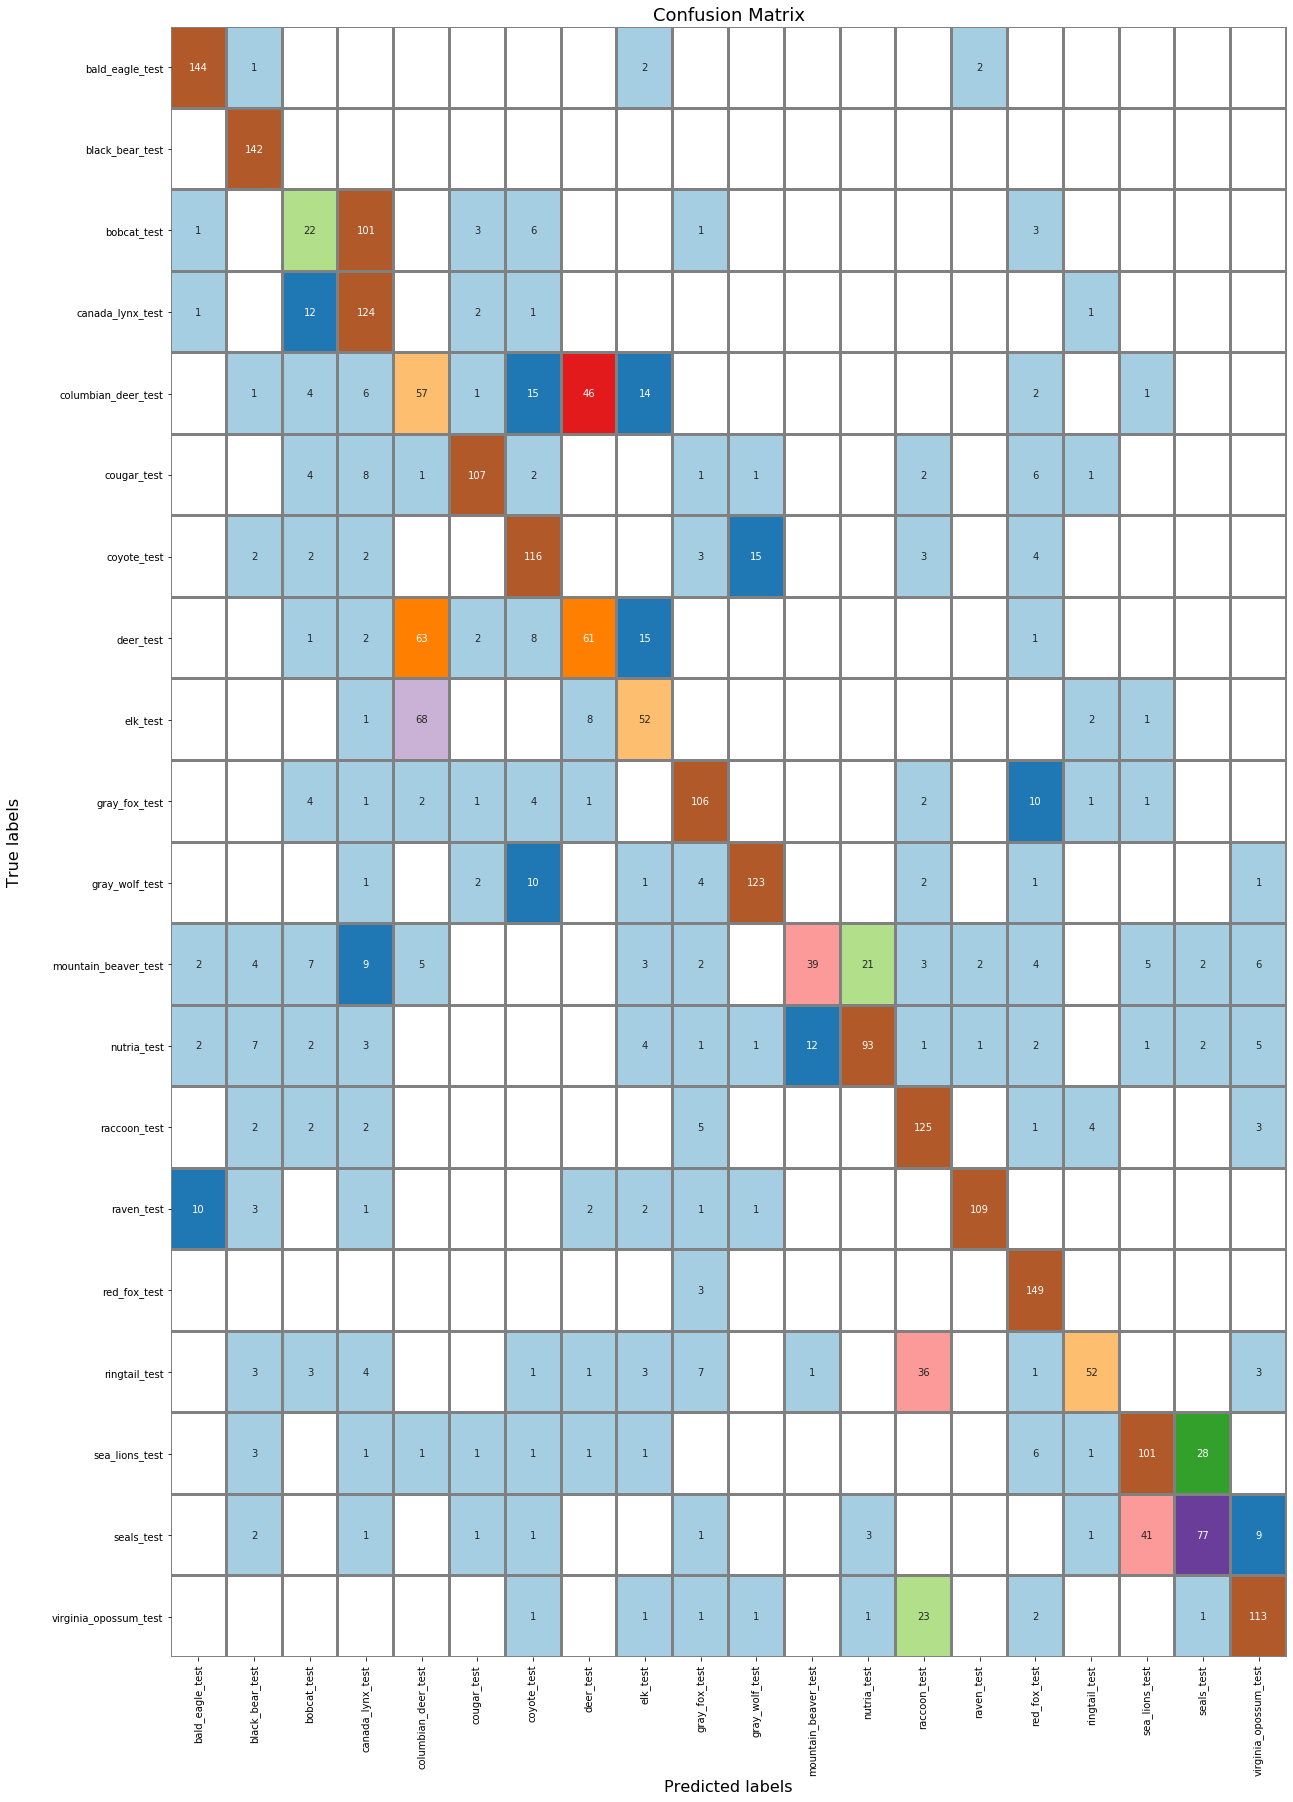

In [75]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# classes = classes[unique_labels(y_true, y_pred)]
# Figure adjustment and heatmap plot
f = plt.figure(figsize=(20,30))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, vmax=100, cbar=False, cmap='Paired', mask=(cm==0), fmt=',.0f', linewidths=2, linecolor='grey', ); 

# labels
ax.set_xlabel('Predicted labels', fontsize=16);
ax.set_ylabel('True labels', labelpad=30, fontsize=16); 
ax.set_title('Confusion Matrix', fontsize=18); 
ax.xaxis.set_ticklabels(labels, rotation=90); 
ax.yaxis.set_ticklabels(labels, rotation=0);
ax.set_facecolor('white')

#### Top-k Categorical Accuracy

In [76]:
import functools
from keras.metrics import top_k_categorical_accuracy

In [77]:


top_5_accuracy = functools.partial(top_k_categorical_accuracy, k=5)

In [78]:

import functools

top10_acc = functools.partial(top_k_categorical_accuracy, k=10)

top10_acc.__name__ = 'top10_acc'

top3_acc = functools.partial(top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

cnn.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy", top3_acc, top10_acc])

NameError: name 'opt' is not defined